# Script for calculating daily pr (precipitation) statistics

In [1]:
import numpy
import scipy.stats
import netCDF4

import matplotlib.patches
import matplotlib.gridspec
import datetime as dt

import matplotlib.pyplot as mp
%matplotlib inline
import nc_time_axis

degree_sign = '\N{DEGREE SIGN}'

In [2]:
#Hack to fix missing PROJ4 env var
import os
import conda

conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib
 
from mpl_toolkits import basemap

# Set up details of analysis

### Declare the root directory and names of the files you want to open

* Note 3 different time periods have been set up for these data: 
 * __hist__           (1980-2010) for CMIP6 models,(1970-2000) for CMIP5 models
 * __early_century__  (2015-2045) for CMIP6 models,(2005-2035) for CMIP5 models
 * __late_century__   (2070-2100)
 * the data put out by the different modeling centers comes in different time blocks so we have preprocessed it after download from the ESGF to have these time periods for simplicity.  
  * CMIP6 model projections are for SSP5-8.5 (Shared Socioeconomic Pathway for greenhouse gas and aerosol forcings)
 * CMIP5 model projections are for RCP 8.5 (Representative Concentration Pathway)
 * Note that the SSP starts later than the data for the RCP so the early century time periods don't match
 
### You can choose which model to analyze

Do this by changing model_index= to a value 0 through 5. Values 0 through 3 are CMIP6 models; 4, 5 are CMIP5 models.

### You can to choose whether you use the (2070-2100) or (2005-2035) time periods

Do this by selecting **`late_century = True`** or **`early_century = True`** below

In [3]:
#acronyms for climate models for which daily temp. and prec. data has been downloaded from selected simulations
model_names = ['CESM2-WACCM', 
               'GFDL-CM4',
               'MPI-ESM1-2-LR',
               'MRI-ESM2',
              'CESM1-CAM5',
               'GFDL-CM3',
              ]

In [4]:
################ Choose model #####################

model_index = 0

# 0 CESM2-WACCM
# 1 GFDL-CM4
# 2 MPI-ESM-2-LR
# 3 MRI-ESM2
# 4 CESM-CAM5 (CMIP5)
# 5 GFDL-CM3 (CMIP5)
cmip6 = model_index< 4     #a Boolean variable used for handling differences between CMIP5 and CMIP6 data
model_name = model_names[model_index]

#a string for use in labels later
if cmip6:
    scenario = 'SSP5-8.5'
else:
        scenario ='RCP8.5'
print ('model_name  ',model_name,';   scenario ',scenario)

model_name   CESM2-WACCM ;   scenario  SSP5-8.5


In [33]:
# specify whether you want to use the early or late period

late_century, early_century   = True, False # selects 2070 - 2100 
#early_century, late_century  = True, False # selects 2015 - 2045 for CMIP6 models, 2005 - 2035 for CMIP5 models


### Specify whether you want to use a land mask i.e., within your region only include land points


In [34]:
#True for landmasking, that is only include events over land
maskit = False


### Choose season for analysis (or create your own)

In [35]:
# SEASONS

season = 'Nov - March'; months=[11,12,1,2,3]
#season='DJF'; months=[12,1,2]
#season='MAM'; months=[3,4,5]
#season='JJA'; months=[6,7,8]
#season='SON'; months=[9,10,11]
#season='annual'; months=[1,2,3,4,5,6,7,8,9,10,11,12]

### Get the file names corresponding to the details you chose

In [36]:
file_root = '/scratch/datasets/aos112_2020/AOS112_Lab_2_Extreme_daily_data/' + ('cmip6/' if cmip6 else 'cmip5/')
file_root_obs = '/scratch/datasets/aos112_2020/AOS112_Lab_2_Extreme_daily_data/observations/'



hist_filename      = 'pr_day_' + model_names[model_index] + '_historical_r1i1p1_' \
                        + ('19800101-20091231.nc' if cmip6 else '19710101-20001131.nc')

ssp_early_filename = 'pr_day_' + model_names[model_index] + ('_ssp585_' if cmip6 else '_rcp85_') + 'r1i1p1_' \
                        + ('20150101-20441231.nc' if cmip6 else '20060101-20351231.nc')

ssp_late_filename  = 'pr_day_' + model_names[model_index] + ('_ssp585_' if cmip6 else '_rcp85_') + 'r1i1p1_' \
                        + ('20700101-20991231.nc' if cmip6 else '20710101-21001231.nc')



#  list files to check the paths are correct 
!ls $file_root_obs$obs_filename
!ls $file_root$hist_filename
!ls $file_root$rcp_early_filename
!ls $file_root$rcp_late_filename

#!ls $file_root #uncomment this line to see all model filenames

aos112_lab2_daily_pr.ipynb	   aos112_lab2_daily_tas.ipynb
aos112_lab2_daily_tas_cesm2.ipynb  CC_superScaling.ipynb
/scratch/datasets/aos112_2020/AOS112_Lab_2_Extreme_daily_data/cmip6/pr_day_CESM2-WACCM_historical_r1i1p1_19800101-20091231.nc
aos112_lab2_daily_pr.ipynb	   aos112_lab2_daily_tas.ipynb
aos112_lab2_daily_tas_cesm2.ipynb  CC_superScaling.ipynb
aos112_lab2_daily_pr.ipynb	   aos112_lab2_daily_tas.ipynb
aos112_lab2_daily_tas_cesm2.ipynb  CC_superScaling.ipynb


In [37]:
#CPC precip observational estimate has been interpolated onto model grids just for central US region and specific models
#(To be upgraded in some future lab)
obs_file_array = ['cpc_precip_conus_v1_1981_2006_regrid_to_CESM.nc',
                    'cpc_precip_conus_v1_1981_2006_regrid_to_GFDL.nc',
                    'cpc_precip_conus_v1_1981_2006_regrid_to_HadGEM.nc']

if not cmip6: obs_filename = obs_file_array[model_index-4] 

### Define the region to analyze (use one that's there, or create your own)
- you can check the map in the next cell to see if the boundaries are where you want, and adjust if needed
- give your region a mnemonic name for labels on plots later
- observed data set provided is for Central US only

In [38]:
#Example regions
#lat_lo = 30; lat_hi = 45; lon_lo = 230; lon_hi = 250; region='California'
#lat_lo = 35; lat_hi = 45; lon_lo = 255; lon_hi = 275; region='Central US'
#lat_lo = -45; lat_hi = -10.; lon_lo = 110; lon_hi = 156; region='Australia'
#lat_lo = -10; lat_hi = 10; lon_lo = -25; lon_hi = 60; region='Equatorial Africa'
#lat_lo = 40; lat_hi = 60; lon_lo = 80; lon_hi = 110; region='Central Asia'
#lat_lo = -10; lat_hi = 10; lon_lo = 160; lon_hi = 240; region='Tropical Pacific'
#lat_lo = 75; lat_hi = 90; lon_lo = 0; lon_hi = 360; region='Arctic Circle'
#lat_lo = 20; lat_hi = 35; lon_lo = 100; lon_hi = 120; region='SE China'

#Change this line or replace with one from above (without # sign) to change region
lat_lo = -10; lat_hi = 10; lon_lo = 25; lon_hi = 50; region='Kenya'

if region=='Central US' and not cmip6:
    obs=True
else:
    obs=False

### Plot this latitude/longitude range to visualize it

Text(0.5, 1.1, 'Kenya')

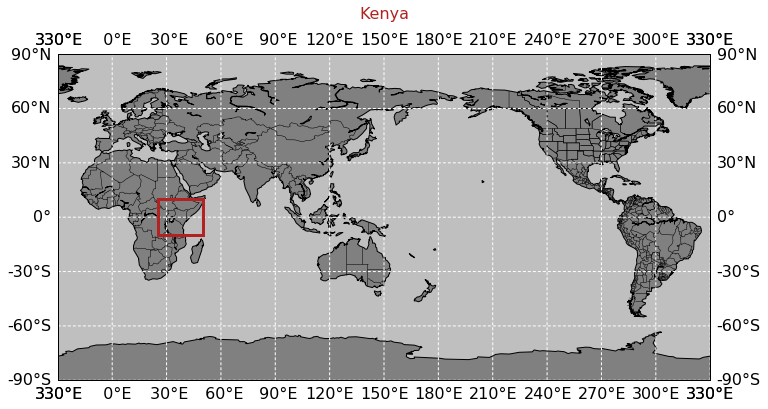

In [39]:
def format_lons(lon):
    return '%3d' % lon + '\N{DEGREE SIGN}E'
def format_lats(lat):
    if lat<0:
        return '%2d' % lat + '\N{DEGREE SIGN}S'
    elif lat==0:
        return '%1d' % lat + '\N{DEGREE SIGN}'
    elif lat>0:
        return '%2d' % lat + '\N{DEGREE SIGN}N'
    
region_lats = [lat_lo, lat_hi, lat_hi, lat_lo]
region_lons = [lon_lo, lon_hi, lon_hi, lon_lo]

fontsize=16

fig = mp.figure(figsize=(12,6))
ax = fig.add_subplot(111)

ax_map = basemap.Basemap(projection='cyl', ax=ax, llcrnrlon=-30., llcrnrlat=-90., urcrnrlon=330., urcrnrlat=90.)
ax_map.drawcoastlines()
ax_map.fillcontinents(color='0.5', lake_color='0.75')
ax_map.drawmapboundary(fill_color='0.75')
ax_map.drawstates()
ax_map.drawcountries()

ax_map.drawparallels(numpy.arange(-90,91,30), labels=[1,1,1,1], dashes=[3,2], fontsize=fontsize, fmt=format_lats, color='1')
ax_map.drawmeridians(numpy.arange(-30,341,30), labels=[1,1,1,1], dashes=[3,2], fontsize=fontsize, fmt=format_lons, color='1')

x1,y1 = ax_map(lon_lo, lat_lo)
x2,y2 = ax_map(lon_lo, lat_hi)
x3,y3 = ax_map(lon_hi, lat_hi)
x4,y4 = ax_map(lon_hi, lat_lo)
poly = matplotlib.patches.Polygon([(x1,y1),(x2,y2),(x3,y3),(x4,y4)],facecolor='None',\
                                  edgecolor='firebrick',linewidth=3,zorder=3)
mp.gca().add_patch(poly)

ax.text(s=region, x=0.5, y=1.1, ha='center', va='bottom', transform=ax.transAxes, fontsize=fontsize, color='firebrick')

### Open the data you selected above
- This cell takes a minute to run due to large data sets

In [40]:
# open historical
ncfile_hist = netCDF4.Dataset(file_root + hist_filename, 'r', format='NETCDF4')
time_variable_hist = ncfile_hist.variables['time']
time_variable_hist_converted = netCDF4.num2date(time_variable_hist[:], time_variable_hist.units, time_variable_hist.calendar)

# open RCP 8.5
if late_century: # if rcp_late=True, open the later time frame (2070-2100)
    ncfile_ssp = netCDF4.Dataset(file_root + ssp_late_filename, 'r', format='NETCDF4')
    ssp_years = '2071-2100'
    hist_years = '1970-2000'
else: # otherwise, open the earlier time frame (2005-2035)
    ncfile_ssp = netCDF4.Dataset(file_root + ssp_early_filename, 'r', format='NETCDF4')
    ssp_years = '2006-2035'
    hist_years = '1971-2000'

time_variable_ssp = ncfile_ssp.variables['time']
time_variable_ssp_converted = netCDF4.num2date(time_variable_ssp[:], time_variable_ssp.units, \
                                               time_variable_ssp.calendar)

model_lat = ncfile_hist.variables['lat'][:]
model_lon = ncfile_hist.variables['lon'][:]

if obs:
    ncfile_obs = netCDF4.Dataset(file_root_obs + obs_filename, 'r', 'NetCDF4')
    obs_lat = ncfile_obs.variables['lat'][:]
    obs_lon = ncfile_obs.variables['lon'][:]
    time_variable_obs = ncfile_obs.variables['time']
    time_variable_obs_converted = netCDF4.num2date(time_variable_obs[:], time_variable_obs.units, 'standard')

### Get latitude and longitude values where the region is located

In [41]:
model_lon_indices = (model_lon>=lon_lo) & (model_lon<=lon_hi)
model_lat_indices = (model_lat>=lat_lo) & (model_lat<=lat_hi)

### Define the time periods to analyze

In [42]:
# historical
if cmip6:    
    hist_start   = dt.datetime(1980,1,1)
    hist_end     = dt.datetime(2009,12,31)
else:
    hist_start   = dt.datetime(1971,1,1)
    hist_end     = dt.datetime(2000,1,1)

# SSP585
if late_century:
    ssp_start   = dt.datetime(2070,1,1)
    ssp_end     = dt.datetime(2099,12,31)
else:
    if cmip6:    
        ssp_start = dt.datetime(2015,1,1)
        ssp_end = dt.datetime(2044,12,31)
    else:
        ssp_start = dt.datetime(2006,1,1)
        ssp_end = dt.datetime(2034,12,31)
# obs start and end
if obs:
    obs_start = dt.datetime(1981,1,1)
    obs_end = dt.datetime(2007,1,1)

### Code to pull out proper time, latitudes, and longitudes
- This cell takes a while to run due to large data sets

In [43]:
time_indices_hist = numpy.array([(t.month in months)&(t.year in range(hist_start.year, hist_end.year+1)) 
                                 for t in time_variable_hist_converted])

time_indices_ssp  = numpy.array([(t.month in months)&(t.year in range(ssp_start.year, ssp_end.year+1)) 
                                for t in time_variable_ssp_converted])


model_hist_prfull = ncfile_hist.variables['pr'][time_indices_hist,:,:][:,model_lat_indices,:][:,:,model_lon_indices]*86400.
model_ssp_prfull = ncfile_ssp.variables['pr'][time_indices_ssp,:,:][:,model_lat_indices,:][:,:,model_lon_indices]*86400.

if obs:
    time_indices_obs = numpy.array([(t.month in months)&(t.year in range(obs_start.year, obs_end.year+1)) for t in time_variable_obs_converted])
    obs_pr = ncfile_obs.variables['precip'][time_indices_obs,:,:]
    obs_pr = obs_pr[~numpy.isnan(obs_pr)]
print ('time_indices and model_hist, _ssp pr data arranged')

time_indices and model_hist, _ssp pr data arranged


### Creates a landmask by interpolating a previously defined map of land coverage into the resolution of the current model. (Enable landmask by changing "maskit=True")


### Turn non-land values into NaN
- Now we loop through each time index of our matrix of precip values, and turn each value which is not over land into a NaN value (not a number). The advantage of turning these values into NaNs will become apparent in the following sections. In essence, we can now take counts of the magnitude of precip events without altering the mean or other relevant statistics (which would be the case if we opted to turn these values into zeros or some other numerical value). 

In [44]:
mask_files = ['sftlf_fx_CESM2-WACCM_historical_r1i1p1f1_gn.nc' ,
              'sftlf_fx_GFDL-CM4_historical_r1i1p1f1_gr1.nc',
             'sftlf_fx_MPI-ESM1-2-LR_historical_r1i1p1f1_gn.nc',
              'sftlf_fx_MRI-ESM2-0_historical_r1i1p1f1_gn.nc',
              'sftlf_fx_CESM2-WACCM_historical_r1i1p1f1_gn.nc' ,
              'sftlf_fx_GFDL-CM4_historical_r1i1p1f1_gr2.nc',
             ]


if maskit and model_index < 6:
    landmask     = netCDF4.Dataset('/home/datasets/aos112_2020/AOS112_Lab_2_Extreme_daily_data/masks/' + mask_files[model_index],'r').variables['sftlf'][:] 
    reg_landmask = landmask[model_lat_indices,:][:,model_lon_indices]
    # reglandmask refers to the regional landmask, so now we take the slice out of the landmask matrix defined above  
    # which corresponds to the region we selected
    for k in numpy.arange(len(model_hist_prfull)):
        model_hist_prfull[k][reg_landmask<100] = numpy.nan 
    for k in numpy.arange(len(model_ssp_prfull)):
        model_ssp_prfull[k][reg_landmask<100] = numpy.nan

model_hist_pr = model_hist_prfull
model_ssp_pr = model_ssp_prfull

# ==================================================
# Histograms of daily precipitation
# ==================================================

### Code to choose a lower threshold for precipitation (default:  values of 0 are included in histogram)

In [45]:
threshold = 0.0 # mm/day   
#If threshold not 0.0, then mean values calculated below do not represent true time averages, 
#  but instead are averages over days with precipitation > threshold

model_hist_pr_over_threshold = model_hist_pr[model_hist_pr>threshold]
model_ssp_pr_over_threshold = model_ssp_pr[model_ssp_pr>threshold]
if obs:
    obs_pr_over_threshold = obs_pr[obs_pr>=threshold]

### Calculate the means of the time periods for your region
 * Note that even though you start with daily data, this will be the mean over the season and decades that you chose, as well as over all grid points in the region you chose, so this is like the quantities computed in  Lab 1
 * Detail: the mean over the region is not an area-weighted average

In [46]:
hist_mean = numpy.mean(model_hist_pr_over_threshold)
ssp_mean = numpy.mean(model_ssp_pr_over_threshold)
if obs:
    obs_mean = numpy.mean(obs_pr_over_threshold)

#values rounded to 2 decimal places
print(str(round(hist_mean,2))+' mm/day'+' is the mean for historical')
print(str(round(ssp_mean,2))+' mm/day'+' is the mean for ', scenario)

3.47 mm/day is the mean for historical
5.11 mm/day is the mean for  SSP5-8.5


### Compute your favorite percentile in each time period
 * note for precipitation there are typically a lot of non-raining days and days with very low values, so if you choose prec_lo to be e.g. the 5th percentile, you will likely get zero. 
 * Even the 50th percentile (the median) is typically quite a low value---compare it to the mean above
 * The probability distribution drops more slowly at high values than for temperature, so values at the 99.9th, 99.99th or even 99.999th can be of interest to see changes in the really large events (if you have too small a region, you may have trouble getting good statistics for the 99.999th) 

In [47]:
perc_hi = 99.99 # 99.99th percentile
perc_lo = 50 # 50th percentile

value_hi_hist = scipy.stats.scoreatpercentile(model_hist_pr_over_threshold, perc_hi)
value_lo_hist = scipy.stats.scoreatpercentile(model_hist_pr_over_threshold, perc_lo)

value_hi_ssp = scipy.stats.scoreatpercentile(model_ssp_pr_over_threshold, perc_hi)
value_lo_ssp = scipy.stats.scoreatpercentile(model_ssp_pr_over_threshold, perc_lo)

if obs:
    value_hi_obs = scipy.stats.scoreatpercentile(obs_pr_over_threshold, perc_hi)
    value_lo_obs = scipy.stats.scoreatpercentile(obs_pr_over_threshold, perc_lo)

### Print out these percentiles; how is the distribution changing?
 * fractional changes in some of the percentiles will be printed out after the histograms, below

In [48]:
if obs:
    print(str(value_hi_obs)+' mm/day'+' is the '+str(perc_hi)+'th percentile for observations')

#values rounded to 2 decimal places
print(str(round(value_hi_hist,2))+' mm/day'+' is the '+str(perc_hi)+'th percentile for historical')
print(str(round(value_hi_ssp,2))+' mm/day'+' is the '+str(perc_hi)+'th percentile for ', scenario)
print()

if obs:
    print(str(value_lo_obs)+' mm/day'+' is the '+str(perc_lo)+'th percentile for observations')

print(str(round(value_lo_hist,2))+' mm/day'+' is the '+str(perc_lo)+'th percentile for historical')
print(str(round(value_lo_ssp,2))+' mm/day'+' is the '+str(perc_lo)+'th percentile for ', scenario)

74.35 mm/day is the 99.99th percentile for historical
153.21 mm/day is the 99.99th percentile for  SSP5-8.5

0.42 mm/day is the 50th percentile for historical
1.35 mm/day is the 50th percentile for  SSP5-8.5


### Define the bins and calculate the histograms

* Note that `density=True` means the resulting histogram will be a probability density function (frequency of occurrence normalized by total counts and by bin width).
* Setting `density=False` will give you the counts alone, and you can normalize this later as needed.
* default (bins=numpy.logspace...) uses bins that are constant in log(precip) (i.e., they get wider for higher precip). This helps to have enough  values per bin to have statistical significance at high precip.
* if you get results in the upper bins that tend to jump around due to having too few values, you can  reduce the number of bins to have more counts per bin 

In [49]:
Nbins=90 #100  #sets the number of bins for the histogram
#  binning range set by the maximum precip encountered times a factor slightly larger than one  e.g., 1.1 
if obs:
    bins = numpy.logspace(-1,numpy.log10(max(obs_pr.max(), model_ssp_pr[~numpy.isnan(model_ssp_pr)].max(), 
                                             model_hist_pr[~numpy.isnan(model_hist_pr)].max())*1.1),Nbins) 
                                                # log spaced bins
else:
    bins = numpy.logspace(-1,numpy.log10(max(model_ssp_pr[~numpy.isnan(model_ssp_pr)].max(), 
                                             model_hist_pr[~numpy.isnan(model_hist_pr)].max())*1.1),Nbins)
                                                # log spaced bins

        #bins = numpy.linspace(0.1,model_rcp_pr.max(),Nbins) # linearly spaced bins
hist_histogram, bin_edges = numpy.histogram(model_hist_pr[~numpy.isnan(model_hist_pr)], bins=bins, density=True)
ssp_histogram, bin_edges = numpy.histogram(model_ssp_pr[~numpy.isnan(model_ssp_pr)], bins=bins, density=True)

if obs:
    obs_histogram, bin_edges = numpy.histogram(obs_pr, bins=bins, density=True)

bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
bin_width = numpy.diff(bin_edges)

### Make histogram plots (linear y-scale)

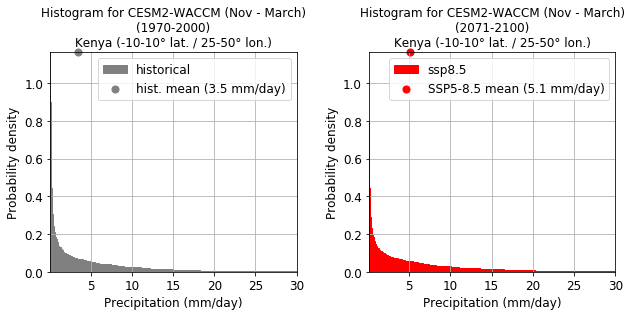

In [50]:
fig = mp.figure(figsize=(9,4.5))
fontsize=12

ax1 = fig.add_subplot(121)
ax1.bar(bin_centers, hist_histogram, align='center', width=bin_width, color='0.5', edgecolor='0.5', label='historical')
ax1.set_xlim(bins[0], 30)  #only showing x-axis up to given value 
ax1.set_ylim(0, hist_histogram[0])
ax1.tick_params(labelsize=fontsize)
ax1.set_ylabel('Probability density', fontsize=fontsize)
ax1.set_xlabel('Precipitation (mm/day)', fontsize=fontsize)
ax1.set_title('Histogram for '+model_name+' ('+season+')'+'\n('+hist_years+')\n'+region+' ('+str(lat_lo)+'-'+str(lat_hi)+degree_sign+' lat. / '+str(lon_lo)+'-'+str(lon_hi)+degree_sign+' lon.)', fontsize=fontsize)
ax1.scatter(x=hist_mean, y=hist_histogram[0], s=50, marker='o', clip_on=False, color='0.5', label='hist. mean ('+'{0:.1f}'.format(hist_mean)+' mm/day)')
if obs:
    ax1.plot(bin_centers, obs_histogram, lw=2, c='0.1', label='observations')
    ax1.scatter(x=obs_mean, y=hist_histogram[0], s=50, marker='o', clip_on=False, color='0.1', label='obs. mean ('+'{0:.1f}'.format(obs_mean)+' mm/day)')
ax1.grid()

handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[::-1], labels[::-1], loc=0, fontsize=fontsize)

ax2 = fig.add_subplot(122)
ax2.bar(bin_centers, ssp_histogram, align='center', width=bin_width, color='red', edgecolor='red', label='ssp8.5')
ax2.set_xlim(bins[0], 30)
ax2.set_ylim(0, hist_histogram[0])
ax2.tick_params(labelsize=fontsize)
ax2.set_ylabel('Probability density', fontsize=fontsize)
ax2.set_xlabel('Precipitation (mm/day)', fontsize=fontsize)
ax2.set_title('Histogram for '+model_name+' ('+season+')'+'\n('+ssp_years+')\n'+region+' ('+str(lat_lo)+'-'+str(lat_hi)+degree_sign+' lat. / '+str(lon_lo)+'-'+str(lon_hi)+degree_sign+' lon.)', fontsize=fontsize)
ax2.scatter(x=ssp_mean, y=hist_histogram[0], s=50, marker='o', clip_on=False, c='red', label=scenario+' mean ('+'{0:.1f}'.format(ssp_mean)+' mm/day)')
ax2.grid()

handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles[::-1], labels[::-1], loc=0, fontsize=fontsize)

fig.tight_layout()

### Make combined, linear y-scale plot

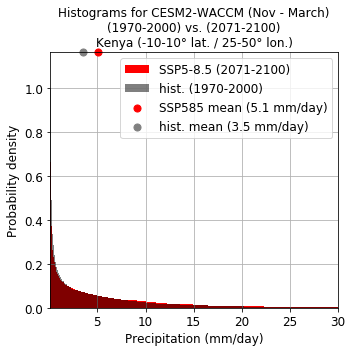

In [51]:
fig = mp.figure(figsize=(5,5))
fontsize=12

ax = fig.add_subplot(111)
ax.bar(bin_centers, hist_histogram, align='center', width=bin_width, color='0', lw=0, label='hist. ('+hist_years+')', zorder=1, alpha=0.5)
ax.bar(bin_centers, ssp_histogram, align='center', width=bin_width, color='red', lw=0, label=scenario+' ('+ssp_years+')', zorder=0)
if obs:
    ax.plot(bin_centers, obs_histogram, lw=2, c='0.1', label='observations')
xmax=30  # to zoom in x, change this value
ax.set_xlim(bins[0], xmax) 
# set ymax to value of first bin
ymax=hist_histogram[0]   # to zoom in y, change this value, e.g., ymax=.05
ax.set_ylim(0, ymax)
ax.set_ylabel('Probability density', fontsize=fontsize)
ax.set_xlabel('Precipitation (mm/day)', fontsize=fontsize)
ax.set_title('Histograms for '+model_name+' ('+season+')'+'\n('+hist_years+') vs. ('+ssp_years+')\n'+region+' ('+str(lat_lo)+'-'+str(lat_hi)+degree_sign+' lat. / '+str(lon_lo)+'-'+str(lon_hi)+degree_sign+' lon.)', fontsize=fontsize)

# add means
ax.scatter(x=hist_mean, y=ymax, s=50, marker='o', clip_on=False, color='0.5', label='hist. mean ('+'{0:.1f}'.format(hist_mean)+' mm/day)')
ax.scatter(x=ssp_mean, y=ymax, s=50, marker='o', clip_on=False, c='red', label='SSP585 mean ('+'{0:.1f}'.format(ssp_mean)+' mm/day)')
if obs:
    ax.scatter(x=obs_mean, y=hist_histogram[0], s=50, marker='o', clip_on=False, color='0.1', label='obs. mean ('+'{0:.1f}'.format(obs_mean)+' mm/day)')

ax.tick_params(labelsize=fontsize)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc=0, fontsize=fontsize)

ax.set_axisbelow(True)
ax.grid()
fig.tight_layout()

### Make histogram plots (log y-scale)

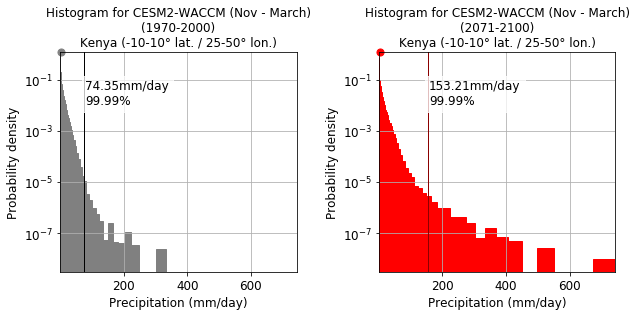

In [52]:
fig = mp.figure(figsize=(9,4.5))
fontsize=12

ax1 = fig.add_subplot(121)
ax1.bar(bin_centers, hist_histogram, align='center', width=bin_width, color='0.5', edgecolor='0.5', label='historical')
ax1.set_xlim(bins[0], bins[-1]) #sets the x-range to go from 1st bin to last bin values
ax1.set_ylim(10**-8.5, hist_histogram[0])
ax1.tick_params(labelsize=fontsize)
ax1.set_ylabel('Probability density', fontsize=fontsize)
ax1.set_xlabel('Precipitation (mm/day)', fontsize=fontsize)
ax1.set_yscale('log')   #this sets the log y-scale
ax1.set_title('Histogram for '+model_name+' ('+season+')'+'\n('+hist_years+')\n'+region+' ('+str(lat_lo)+'-'+str(lat_hi)+degree_sign+' lat. / '+str(lon_lo)+'-'+str(lon_hi)+degree_sign+' lon.)', fontsize=fontsize)
if obs:
    ax1.plot(bin_centers, obs_histogram, lw=2, c='0.1')
ax1.axvline(value_hi_hist, lw=1, c='0')
t=ax1.text(s='{:.2f}'.format(value_hi_hist)+'mm/day\n'+str(perc_hi)+'%', ha='left', va='top', x=value_hi_hist+5, y=10**-1, fontsize=fontsize)
t.set_bbox(dict(color='1', alpha=0.75))
ax1.scatter(x=hist_mean, y=hist_histogram[0], s=50, marker='o', clip_on=False, color='0.5', label='hist. mean ('+'{0:.1f}'.format(hist_mean)+' mm/day)')
ax1.grid()
# DN note label not showing

ax2 = fig.add_subplot(122)
ax2.bar(bin_centers, ssp_histogram, align='center', width=bin_width, color='red', edgecolor='red', label=scenario)
ax2.set_xlim(bins[0], bins[-1])
ax2.set_ylim(10**-8.5, hist_histogram[0])
ax2.tick_params(labelsize=fontsize)
ax2.set_ylabel('Probability density', fontsize=fontsize)
ax2.set_xlabel('Precipitation (mm/day)', fontsize=fontsize)
ax2.set_yscale('log')
ax2.set_title('Histogram for '+model_name+' ('+season+')'+'\n('+ssp_years+')\n'+region+' ('+str(lat_lo)+'-'+str(lat_hi)+degree_sign+' lat. / '+str(lon_lo)+'-'+str(lon_hi)+degree_sign+' lon.)', fontsize=fontsize)
ax2.axvline(value_hi_ssp, lw=1, c='darkred')
t=ax2.text(s='{:.2f}'.format(value_hi_ssp)+'mm/day\n'+str(perc_hi)+'%', ha='left', va='top', x=value_hi_ssp+5, y=10**-1, fontsize=fontsize)
t.set_bbox(dict(color='1', alpha=0.75))
ax2.scatter(x=ssp_mean, y=hist_histogram[0], s=50, marker='o', clip_on=False, c='red', label=scenario +' mean ('+'{0:.1f}'.format(ssp_mean)+' mm/day)')
ax2.grid()
 
fig.tight_layout()

### Make combined log y-scale plot

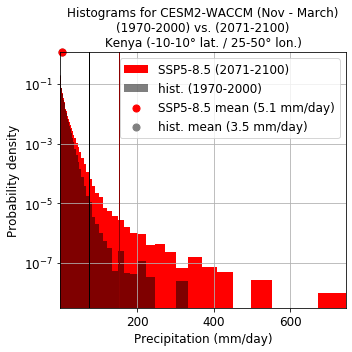

In [53]:
fig = mp.figure(figsize=(5,5))
fontsize=12

ax = fig.add_subplot(111)
ax.bar(bin_centers, hist_histogram, align='center', width=bin_width, color='0', lw=0, label='hist. ('+hist_years+')', zorder=1, alpha=0.5)
ax.bar(bin_centers, ssp_histogram, align='center', width=bin_width, color='red', lw=0, label=scenario+' ('+ssp_years+')', zorder=0)
ax.set_xlim(bins[0], bins[-1])   #sets the x-range to go from 1st bin to last bin values
ax.set_ylim(10**-8.5, hist_histogram[0])
ax.set_ylabel('Probability density', fontsize=fontsize)
ax.set_xlabel('Precipitation (mm/day)', fontsize=fontsize)
ax.set_title('Histograms for '+model_name+' ('+season+')'+'\n('+hist_years+') vs. ('+ssp_years+')\n'+region+' ('+str(lat_lo)+'-'+str(lat_hi)+degree_sign+' lat. / '+str(lon_lo)+'-'+str(lon_hi)+degree_sign+' lon.)', fontsize=fontsize)

ax.scatter(x=hist_mean, y=hist_histogram[0], s=50, marker='o', clip_on=False, color='0.5', label='hist. mean ('+'{0:.1f}'.format(hist_mean)+' mm/day)')
ax.scatter(x=ssp_mean, y=hist_histogram[0], s=50, marker='o', clip_on=False, color='red', label=scenario+' mean ('+'{0:.1f}'.format(ssp_mean)+' mm/day)')
ax.axvline(value_hi_hist, lw=1, c='0')
ax.axvline(value_hi_ssp, lw=1, c='darkred')

ax.set_yscale('log') # use log scale
ax.tick_params(labelsize=fontsize)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc=0, fontsize=fontsize)

ax.grid()
fig.tight_layout()

In [54]:
### Calculate the fractional change of the mean of the distributions

In [55]:
print('Ratio of mean future/historical =',str(round(ssp_mean/hist_mean,2)))

Ratio of mean future/historical = 1.47


### Calculate the fractional change of non-rainy days (where precipitation=0)

In [56]:
if threshold==0.0:
    print('Ratio of non-rainy days future/historical =',str(round(ssp_histogram[0]/hist_histogram[0],2)))
else:
    print('Threshold must be set to 0.0 mm/day')

Ratio of non-rainy days future/historical = 0.68


### Calculate how the value at a given historical percentile changes in the RCP 8.5 runs

In [57]:
perc_in_hist = perc_hi # set above, but change here if desired

# calculate the value (in degrees Celsius) that is at the 99th percentile
value_hist = scipy.stats.scoreatpercentile(model_hist_pr_over_threshold, perc_in_hist)
print('HISTORICAL: ', '{:.1f}'.format(value_hist)+' mm/day'+' is the '+str(perc_in_hist)+'th percentile')

# now calculate how the probability of this event changes in ssp 8.5
perc_in_ssp = scipy.stats.percentileofscore(model_ssp_pr_over_threshold.flatten(), value_hist)
print('FUTURE:     ', '{:.4f}'.format(perc_in_ssp)+'% is the percentile for this value in ', scenario)

print()

# calculate the fractional increase in likelihood
fraction = (100-perc_in_ssp)/(100-perc_in_hist)
print('This precipitation value has become '+'{:.1f}'.format(fraction)+' times as likely in '+ scenario +' relative to historical')

HISTORICAL:  74.3 mm/day is the 99.99th percentile
FUTURE:      99.8891% is the percentile for this value in  SSP5-8.5

This precipitation value has become 11.1 times as likely in SSP5-8.5 relative to historical


### Count the number of occurrences above this percentile value

* Approximate by counting events above this percentile value

In [58]:
print('HISTORICAL: ', numpy.sum(model_hist_pr_over_threshold>=value_hist),'is the number of precipitation days above the',perc_in_hist,'th percentile')
print('FUTURE:     ', numpy.sum(model_ssp_pr_over_threshold>=value_hist),'is the number of precipitation days above the historical',perc_in_hist,'th percentile for ', scenario)
print()
print('Days above the historical',perc_in_hist,'th percentile have become '+'{:.2f}'.format(numpy.sum(model_ssp_pr_over_threshold>=value_hist)/numpy.sum(model_hist_pr_over_threshold>=value_hist)),'times as common under '+ scenario +' as in historical')

HISTORICAL:  206 is the number of precipitation days above the 99.99 th percentile
FUTURE:      2290 is the number of precipitation days above the historical 99.99 th percentile for  SSP5-8.5

Days above the historical 99.99 th percentile have become 11.12 times as common under SSP5-8.5 as in historical


# ==================================================
# Extreme value calculations
# ==================================================

### Before we do any calculations, let's visualize what annual extremes look like

* Do this for the historical time period, from 1995 to 2000, for the middle lat/lon in the series

In [59]:
# subset time indices
time_array_hist = time_variable_hist_converted[time_indices_hist]
time_array_ssp = time_variable_ssp_converted[time_indices_ssp]

In [60]:
middle_lat = round(model_hist_pr.shape[1]/2)
middle_lon = round(model_hist_pr.shape[2]/2)

start = 1990
end = 1995 # must not go above 2001
nyears = end-start

# subset time between two years
year_indices_time_span = [t.year in range(start, end) for t in time_array_hist]
time_array_time_span = numpy.array(([dt.datetime(t.year,t.month,t.day) \
                                     for t in time_array_hist[year_indices_time_span]]))
model_hist_pr_time_span = model_hist_prfull[year_indices_time_span, middle_lat, middle_lon]

max_precip_time_span = []
max_precip_time_span_dates = []

for year_idx in range(nyears):
    current_year = time_array_time_span[0].year+year_idx
    year_indices = numpy.array([t.year==current_year for t in time_array_time_span]) # true when current year
    max_precip_time_span.append(numpy.max(model_hist_pr_time_span[year_indices]))
    max_idx = int(numpy.argmax(model_hist_pr_time_span[year_indices]))
    max_precip_time_span_dates.append(time_array_time_span[year_indices][max_idx])

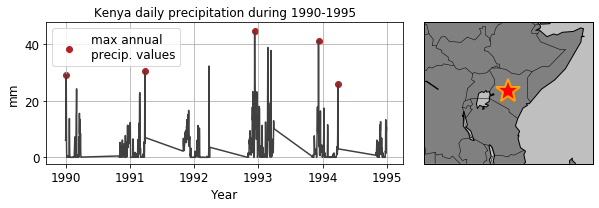

In [61]:
fontsize = 12

grid_lat = model_lat[model_lat_indices][middle_lat]
grid_lon = model_lon[model_lon_indices][middle_lon]

fig = mp.figure(figsize=(8.5,3))

gs = matplotlib.gridspec.GridSpec(1,2, width_ratios=[2,1]) 
ax1 = mp.subplot(gs[0])
ax2 = mp.subplot(gs[1])


ax1.plot(time_array_time_span, model_hist_pr_time_span, c='0.25')
ax1.scatter(max_precip_time_span_dates, max_precip_time_span, color='firebrick', label='max annual\nprecip. values')
ax1.tick_params(labelsize=fontsize)
ax1.set_title(region + ' daily precipitation during '+str(start)+'-'+str(end), fontsize=fontsize)
ax1.set_xlabel('Year', fontsize=fontsize)
ax1.set_ylabel('mm', fontsize=fontsize)
ax1.grid()
legend = ax1.legend(fontsize=fontsize)

ax_map = basemap.Basemap(projection='cyl', ax=ax2, \
                      llcrnrlon=lon_lo-3, \
                      llcrnrlat=lat_lo-3*(lat_lo-3>=-90), \
                      urcrnrlon=lon_hi+3, \
                      urcrnrlat=lat_hi+3*(lat_hi+3<=90))


ax_map.plot(grid_lon, grid_lat, marker='*', markeredgecolor='orange', markeredgewidth=2, \
            markerfacecolor='red', markersize=25)
ax_map.drawcoastlines()
ax_map.fillcontinents(color='0.5', lake_color='0.75')
ax_map.drawmapboundary(fill_color='0.75')
ax_map.drawstates()
ax_map.drawcountries()

fig.tight_layout()

### Collect annual max values for historical precipitation

In [62]:
nyears_hist = time_array_hist[-1].year-time_array_hist[0].year+1
nyears_ssp = time_array_ssp[-1].year-time_array_ssp[0].year+1
#if obs:  nyears_obs = time_array_obs[-1].year-time_array_obs[0].year+1

annual_max_hist_pr = numpy.zeros((nyears_hist, \
                                  sum(model_lat_indices), \
                                  sum(model_lon_indices)))

annual_max_ssp_pr = numpy.zeros((nyears_ssp, \
                                 sum(model_lat_indices), \
                                 sum(model_lon_indices)))

# loop through each year from the beginning to end of "time_array_hist"
for year_idx in range(nyears_hist):
    current_year = time_array_hist[0].year+year_idx
    # get the correct indices of those days
    year_indices = numpy.array([t.year==current_year for t in time_array_hist])
    # for each lat/lon combo, loop through and get the max precip value
    for lat_idx in range(sum(model_lat_indices)):
        for lon_idx in range(sum(model_lon_indices)): 
            annual_max_hist_pr[year_idx, lat_idx, lon_idx] = numpy.nanmax(model_hist_pr[year_indices, lat_idx, lon_idx])
            
# loop through each year from the beginning to end of "time_array_hist"
for year_idx in range(nyears_ssp):
    current_year = time_array_ssp[0].year+year_idx
    # get the correct indices of those days
    year_indices = numpy.array([t.year==current_year for t in time_array_ssp])
    # for each lat/lon combo, loop through and get the max precip value
    for lat_idx in range(sum(model_lat_indices)):
        for lon_idx in range(sum(model_lon_indices)): 
            annual_max_ssp_pr[year_idx, lat_idx, lon_idx] = numpy.nanmax(model_ssp_pr[year_indices, lat_idx, lon_idx])



### Create extreme value distributions

In [63]:
#bins = numpy.logspace(-1,numpy.log10(max(model_ssp_pr.max(), model_hist_pr.max())),100) # log spaced bins
#bins = numpy.linspace(0,270,45) # linearly spaced bins set by hand
bins = numpy.linspace(0,(max(model_ssp_pr[~numpy.isnan(model_ssp_pr)].max(), model_hist_pr[~numpy.isnan(model_hist_pr)].max()))*1.05,45) # linearly spaced bins
hist_histogram, bin_edges = numpy.histogram(annual_max_hist_pr[~numpy.isnan(annual_max_hist_pr)], bins=bins, density=True)
ssp_histogram, bin_edges = numpy.histogram(annual_max_ssp_pr[~numpy.isnan(annual_max_ssp_pr)], bins=bins, density=True)

bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
bin_width = numpy.diff(bin_edges)

### Calculate magnitudes of return intervals

Edit **`return_period`** to change

In [64]:
#####################################################################################
########## CHANGE THE EVENT MAGNITUDE OR RETURN PERIOD YOU WANT TO INSPECT ##########
#####################################################################################
event_magnitude = 100 # mm/day
return_period = 20 # specify the return period (i.e., an X-year event)
#####################################################################################
return_perc = 1-(1/return_period)

return_val_hist = scipy.stats.scoreatpercentile(annual_max_hist_pr[~numpy.isnan(annual_max_hist_pr)], return_perc*100)
return_val_ssp = scipy.stats.scoreatpercentile(annual_max_ssp_pr[~numpy.isnan(annual_max_ssp_pr)], return_perc*100)

if (1-scipy.stats.percentileofscore(annual_max_hist_pr[~numpy.isnan(annual_max_hist_pr)].flatten(), event_magnitude)/100.)!=0:
    return_period_hist = 1/(1-scipy.stats.percentileofscore(annual_max_hist_pr[~numpy.isnan(annual_max_hist_pr)].flatten(), event_magnitude)/100.)
else:
    return_period_hist = 999999
    
if (1-scipy.stats.percentileofscore(annual_max_ssp_pr[~numpy.isnan(annual_max_ssp_pr)].flatten(), event_magnitude)/100.)!=0:
    return_period_ssp = 1/(1-scipy.stats.percentileofscore(annual_max_ssp_pr[~numpy.isnan(annual_max_ssp_pr)].flatten(), event_magnitude)/100.)
else:
    return_period_ssp = 999999
    
    
# print the magnitude of an X-year event
print('HISTORICAL:  The', \
      str(int(return_period))+'-year return value for daily extremes is about',\
      '{:.1f}'.format(return_val_hist),\
      'mm')
print('FUTURE:      The', \
      str(int(return_period))+'-year return value for daily extremes is about',\
      '{:.1f}'.format(return_val_ssp),\
      'mm')

print()

# print the return period of a given magnitude
print('HISTORICAL:  A', \
      str(event_magnitude)+'-mm day has a return period of',\
      '{:.1f}'.format(return_period_hist),\
      'years')
print('FUTURE:      A', \
      str(event_magnitude)+'-mm day has a return period of',\
      '{:.1f}'.format(return_period_ssp),\
      'years')

HISTORICAL:  The 20-year return value for daily extremes is about 58.9 mm
FUTURE:      The 20-year return value for daily extremes is about 96.4 mm

HISTORICAL:  A 100-mm day has a return period of 420.0 years
FUTURE:      A 100-mm day has a return period of 22.4 years


In [65]:
if return_period_hist == 999999 or return_period_ssp==999999:
    print(r'Value of 999999 years for a return period implies that the event magnitude is too high for the region selected!')

### From the  return period of events above the specified threshold, calculate risk ratio etc.
#### This is similar to what is used in probabilistic event attribution for an event of that size
- probability of exceedance of the threshold for historical and RCP, p_0 and p_1, are given by:
- p_0=1/return_period_hist ;  p_1=1/return_period_rcp
- Risk Ratio for RCP/Historical p_1/p_0
- Increased Risk (p_1/p_0 -1)
- Fraction of Attributable Risk (1-p_0/p_1)

In [66]:
print('For p_0 and p_1 the probability of exceeding', event_magnitude,' mm/day in historical/SSP585 scenario')
print('The Risk Ratio for SSP585/Historical p_1/p_0 is a factor of', round(return_period_hist/return_period_ssp,3))
print('The Increased Risk (p_1/p_0 -1) as a percent=', round(return_period_hist/return_period_ssp-1.,3)*100.,'%')
print('The Fraction of Attributable Risk (1-p_0/p_1) as a percent=', round(1-return_period_ssp/return_period_hist,3)*100.,'%')

For p_0 and p_1 the probability of exceeding 100  mm/day in historical/SSP585 scenario
The Risk Ratio for SSP585/Historical p_1/p_0 is a factor of 18.727
The Increased Risk (p_1/p_0 -1) as a percent= 1772.7 %
The Fraction of Attributable Risk (1-p_0/p_1) as a percent= 94.69999999999999 %


### Plot these results

The plots below include the N-year return period value calculated above

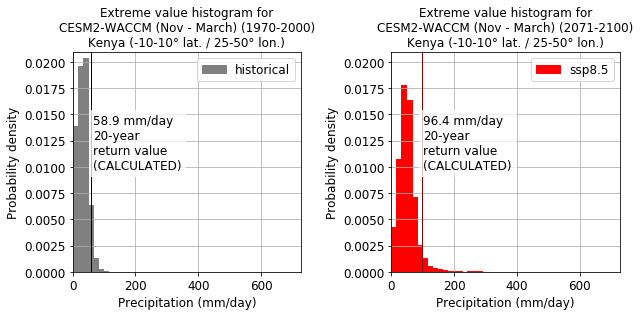

In [67]:
fig = mp.figure(figsize=(9,4.5))
fontsize=12

if return_period >30: t_offset = -5; horiz_align='right'
else:  t_offset = 5; horiz_align='left'

max_val = numpy.max([numpy.max(ssp_histogram), numpy.max(hist_histogram)])

ax1 = fig.add_subplot(121)
ax1.bar(bin_centers, hist_histogram, align='center', width=bin_width, color='0.5', edgecolor='0.5', label='historical')
ax1.set_xlim(bins[0], bins[-1]*1.025)
ax1.set_ylim(0, max_val*1.025)
ax1.tick_params(labelsize=fontsize)
ax1.set_ylabel('Probability density', fontsize=fontsize)
ax1.set_xlabel('Precipitation (mm/day)', fontsize=fontsize)
ax1.set_title('Extreme value histogram for\n'+model_name+' ('+season+')'+' ('+hist_years+')\n'+region+' ('+str(lat_lo)+'-'+str(lat_hi)+degree_sign+' lat. / '+str(lon_lo)+'-'+str(lon_hi)+degree_sign+' lon.)', fontsize=fontsize)
ax1.grid()
ax1.axvline(return_val_hist, lw=1, c='0')
t1=ax1.text(s='{:.1f}'.format(return_val_hist)+' mm/day\n'+str(return_period)+'-year\nreturn value\n(CALCULATED)', \
           ha=horiz_align, va='top', x=return_val_hist+t_offset, y=.015, fontsize=fontsize)
t1.set_bbox(dict(color='1', alpha=0.75))


handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[::-1], labels[::-1], loc=0, fontsize=fontsize)

ax2 = fig.add_subplot(122)
ax2.bar(bin_centers, ssp_histogram, align='center', width=bin_width, color='red', edgecolor='red', label='ssp8.5')
ax2.set_xlim(bins[0], bins[-1]*1.025)
ax2.set_ylim(0, max_val*1.025)
ax2.tick_params(labelsize=fontsize)
ax2.set_ylabel('Probability density', fontsize=fontsize)
ax2.set_xlabel('Precipitation (mm/day)', fontsize=fontsize)
ax2.set_title('Extreme value histogram for\n'+model_name+' ('+season+')'+' ('+ssp_years+')\n'+region+' ('+str(lat_lo)+'-'+str(lat_hi)+degree_sign+' lat. / '+str(lon_lo)+'-'+str(lon_hi)+degree_sign+' lon.)', fontsize=fontsize)
ax2.grid()
ax2.axvline(return_val_ssp, lw=1, c='darkred')
t1=ax2.text(s='{:.1f}'.format(return_val_ssp)+' mm/day\n'+str(return_period)+'-year\nreturn value\n(CALCULATED)', \
           ha=horiz_align, va='top', x=return_val_ssp+t_offset, y=.015, fontsize=fontsize)
t1.set_bbox(dict(color='1', alpha=0.75))

handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles[::-1], labels[::-1], loc=0, fontsize=fontsize)

fig.tight_layout()

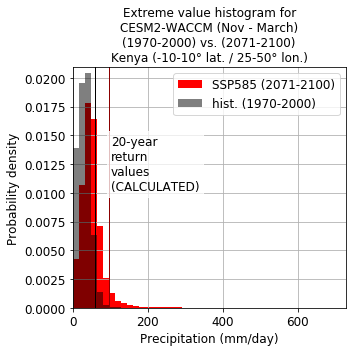

In [68]:
fig = mp.figure(figsize=(5,5))
fontsize=12

ax = fig.add_subplot(111)
ax.bar(bin_centers, hist_histogram, align='center', width=bin_width, color='0', lw=0, label='hist. ('+hist_years+')', zorder=1, alpha=0.5)
ax.bar(bin_centers, ssp_histogram, align='center', width=bin_width, color='red', lw=0, label='SSP585 ('+ssp_years+')', zorder=0, alpha=1)
ax.set_xlim(bins[0], bins[-1]*1.025)
ax.set_ylim(0, max_val*1.025)
ax.set_ylabel('Probability density', fontsize=fontsize)
ax.set_xlabel('Precipitation (mm/day)', fontsize=fontsize)
ax.set_title('Extreme value histogram for\n'+model_name+' ('+season+')\n'+'('+hist_years+') vs. ('+ssp_years+')\n'+region+' ('+str(lat_lo)+'-'+str(lat_hi)+degree_sign+' lat. / '+str(lon_lo)+'-'+str(lon_hi)+degree_sign+' lon.)', fontsize=fontsize)

ax.tick_params(labelsize=fontsize)

ax.axvline(return_val_hist, lw=1, c='0')
ax.axvline(return_val_ssp, lw=1, c='darkred')
t=ax.text(s=str(return_period)+'-year\nreturn\nvalues\n(CALCULATED)', \
           ha='left', va='top', x=max(return_val_hist,return_val_ssp)+5, y=.015, fontsize=fontsize)
t.set_bbox(dict(color='1', alpha=0.75))

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc=0, fontsize=fontsize)

ax.grid()
ax.set_axisbelow(True)
fig.tight_layout()

### Use SciPy to fit extreme value distribution to these histograms

A handful of distribution types is available.  This script uses:
* **`scipy.stats.genextreme.fit()`**, which is the generalized extreme value distro

Others are available, e.g.:
* **`scipy.stats.gamma.fit()`**
* **`scipy.stats.gumbel_r.fit()`**
* **`scipy.stats.frechet_r.fit()`**

Useful links

* For the full list, see the [documentation for continuous distributions in SciPy](https://docs.scipy.org/doc/scipy-0.18.1/reference/tutorial/stats/continuous.html)

* A good intro to the distributions used in extreme value theory is here:  http://www.mathwave.com/articles/extreme-value-distributions.html

* NCAR also has a page for GEV theory:  https://www.ncl.ucar.edu/Applications/extreme_value.shtml

In [69]:
# code to suppress warnings
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore") # comment out this line to see warnings from fitting function
    
    # fitting the distributions to the general extreme value distribution
    hist_fit_params = scipy.stats.genextreme.fit(annual_max_hist_pr[~numpy.isnan(annual_max_hist_pr)], loc=numpy.nanmean(annual_max_hist_pr))#annual_max_hist_pr[~numpy.isnan(annual_max_hist_pr)].mean())
    ssp_fit_params = scipy.stats.genextreme.fit(annual_max_ssp_pr[~numpy.isnan(annual_max_ssp_pr)], loc=numpy.nanmean(annual_max_ssp_pr))#   annual_max_ssp_pr[~numpy.isnan(annual_max_ssp_pr)].mean())

hist_fitted_output = scipy.stats.genextreme.pdf(bin_centers, *hist_fit_params)
ssp_fitted_output = scipy.stats.genextreme.pdf(bin_centers, *ssp_fit_params)

### Use extreme value distributions to calculate how the return period magnitude changes

* Use the **`ppf()`** (the percent point function) to get the **size** of an event with a specific return period
* Use the **`cdf()`** (cumulative distribution function) to get the **percentile** (i.e., return period) of an event of a certain magnitude

In [70]:
#####################################################################################
########## CHANGE THE EVENT MAGNITUDE OR RETURN PERIOD YOU WANT TO INSPECT ##########
#####################################################################################
event_magnitude = 100 # mm/day
return_period = 20 # specify the return period (i.e., an X-year event)
#####################################################################################

return_val_hist = scipy.stats.genextreme.ppf(1-1/return_period, *hist_fit_params)
return_val_ssp = scipy.stats.genextreme.ppf(1-1/return_period, *ssp_fit_params)

return_period_hist = 1/(1-scipy.stats.genextreme.cdf(event_magnitude, *hist_fit_params))
return_period_ssp = 1/(1-scipy.stats.genextreme.cdf(event_magnitude, *ssp_fit_params))


# print the magnitude of an X-year event
print('HISTORICAL:  The', \
      str(int(return_period))+'-year return value for daily extremes is about',\
      '{:.1f}'.format(return_val_hist),\
      'mm')
print('FUTURE:      The', \
      str(int(return_period))+'-year return value for daily extremes is about',\
      '{:.1f}'.format(return_val_ssp),\
      'mm')

print()

# print the return period of a given magnitude
print('HISTORICAL:  A', \
      str(event_magnitude)+'-mm day event has a return period of',\
      '{:.1f}'.format(return_period_hist),\
      'years')
print('FUTURE:      A', \
      str(event_magnitude)+'-mm day event has a return period of',\
      '{:.1f}'.format(return_period_ssp),\
      'years')

HISTORICAL:  The 20-year return value for daily extremes is about 64.0 mm
FUTURE:      The 20-year return value for daily extremes is about 103.7 mm

HISTORICAL:  A 100-mm day event has a return period of 339.1 years
FUTURE:      A 100-mm day event has a return period of 17.2 years


### Create combined extreme value distribution plot, and add fit

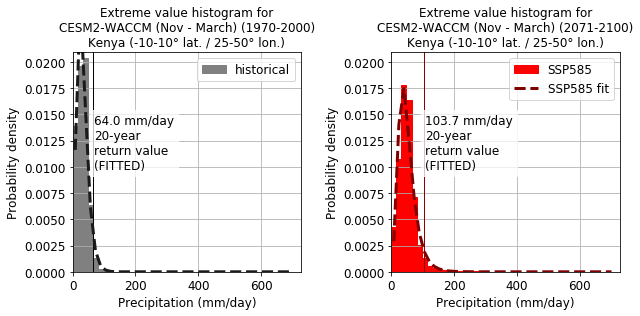

In [71]:
fig = mp.figure(figsize=(9,4.5))
fontsize=12

if return_period >30: t_offset = -5; horiz_align='right'
else:  t_offset = 5; horiz_align='left'

max_val = numpy.max([numpy.max(ssp_histogram), numpy.max(hist_histogram)])

ax1 = fig.add_subplot(121)
ax1.bar(bin_centers, hist_histogram, align='center', width=bin_width, color='0.5', edgecolor='0.5', label='historical')
ax1.set_xlim(bins[0], bins[-1]*1.025)
ax1.set_ylim(0, max_val*1.025)
ax1.tick_params(labelsize=fontsize)
ax1.set_ylabel('Probability density', fontsize=fontsize)
ax1.set_xlabel('Precipitation (mm/day)', fontsize=fontsize)
ax1.set_title('Extreme value histogram for\n'+model_name+' ('+season+')'+' ('+hist_years+')\n'+region+' ('+str(lat_lo)+'-'+str(lat_hi)+degree_sign+' lat. / '+str(lon_lo)+'-'+str(lon_hi)+degree_sign+' lon.)', fontsize=fontsize)
ax1.grid()
ax1.axvline(return_val_hist, lw=1, c='0')
t1=ax1.text(s='{:.1f}'.format(return_val_hist)+' mm/day\n'+str(return_period)+'-year\nreturn value\n(FITTED)', \
           ha=horiz_align, va='top', x=return_val_hist+t_offset, y=.015, fontsize=fontsize)
t1.set_bbox(dict(color='1', alpha=0.75))


handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[::-1], labels[::-1], loc=0, fontsize=fontsize)

ax2 = fig.add_subplot(122)
ax2.bar(bin_centers, ssp_histogram, align='center', width=bin_width, color='red', edgecolor='red', label='SSP585')
ax2.set_xlim(bins[0], bins[-1]*1.025)
ax2.set_ylim(0, max_val*1.025)
ax2.tick_params(labelsize=fontsize)
ax2.set_ylabel('Probability density', fontsize=fontsize)
ax2.set_xlabel('Precipitation (mm/day)', fontsize=fontsize)
ax2.set_title('Extreme value histogram for\n'+model_name+' ('+season+')'+' ('+ssp_years+')\n'+region+' ('+str(lat_lo)+'-'+str(lat_hi)+degree_sign+' lat. / '+str(lon_lo)+'-'+str(lon_hi)+degree_sign+' lon.)', fontsize=fontsize)
ax2.grid()
ax2.axvline(return_val_ssp, lw=1, c='darkred')
t1=ax2.text(s='{:.1f}'.format(return_val_ssp)+' mm/day\n'+str(return_period)+'-year\nreturn value\n(FITTED)', \
           ha=horiz_align, va='top', x=return_val_ssp+t_offset, y=.015, fontsize=fontsize)
t1.set_bbox(dict(color='1', alpha=0.75))

# OVERLAY FITS
ax1.plot(bin_centers, hist_fitted_output, lw=3, ls='--', c='0.1', label='hist. fit')
ax2.plot(bin_centers, ssp_fitted_output, lw=3, ls='--', c='maroon', label='SSP585 fit')

handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles[::-1], labels[::-1], loc=0, fontsize=fontsize)

fig.tight_layout()

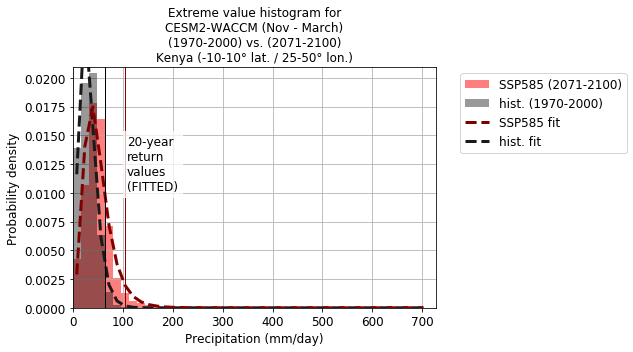

In [72]:
fig = mp.figure(figsize=(9,5))
fontsize=12

ax = fig.add_subplot(111)
ax.bar(bin_centers, hist_histogram, align='center', width=bin_width, color='0', lw=0, label='hist. ('+hist_years+')', zorder=1, alpha=0.4)
ax.bar(bin_centers, ssp_histogram, align='center', width=bin_width, color='red', lw=0, label='SSP585 ('+ssp_years+')', zorder=0, alpha=0.5)
ax.set_xlim(bins[0], bins[-1]*1.025)
ax.set_ylim(0, max_val*1.025)
ax.set_ylabel('Probability density', fontsize=fontsize)
ax.set_xlabel('Precipitation (mm/day)', fontsize=fontsize)
ax.set_title('Extreme value histogram for\n'+model_name+' ('+season+')\n'+'('+hist_years+') vs. ('+ssp_years+')\n'+region+' ('+str(lat_lo)+'-'+str(lat_hi)+degree_sign+' lat. / '+str(lon_lo)+'-'+str(lon_hi)+degree_sign+' lon.)', fontsize=fontsize)
ax.tick_params(labelsize=fontsize)

log_y_plot=False #set True or False to switch log or linear y-axis
if log_y_plot:
    ax.set_ylim(10**-5, max_val*2.)
    ax.set_yscale('log') # use log scale


# OVERLAY FITS
ax.plot(bin_centers, hist_fitted_output, lw=3, ls='--', c='0.1', label='hist. fit')
ax.plot(bin_centers, ssp_fitted_output, lw=3, ls='--', c='maroon', label='SSP585 fit')

ax.axvline(return_val_hist, lw=1, c='0')
ax.axvline(return_val_ssp, lw=1, c='darkred')
t=ax.text(s=str(return_period)+'-year\nreturn\nvalues\n(FITTED)', \
           ha='left', va='top', x=max(return_val_hist,return_val_ssp)+5, y=.015, fontsize=fontsize)
t.set_bbox(dict(color='1', alpha=0.75))

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1],bbox_to_anchor=(1.05, 1.0), loc=2, fontsize=fontsize)

ax.grid()
ax.set_axisbelow(True)
fig.tight_layout()